In [1]:
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import collections
import easyocr
import fitz
import hashlib
import numpy as np
import string
import time
import redis
import json
from minio import Minio
from PIL import Image, ImageDraw, ImageFont
from fontTools.ttLib import TTFont

In [3]:
# Define system variable
print("Loading OCR model...", end=' ')
reader = easyocr.Reader([], gpu=True)  # OCR tool
chars = list(string.digits + string.ascii_letters)  # Get list possible character
print("[Completed]")

client = Minio(
    endpoint="localhost:9000",
    secure=False,
    access_key="p8bBrkOUX3JXTDus",
    secret_key="rimJyqs5zNrNhj55nmU6wEVga6SUUkRD",
)
print("Minio connected,", "bucket found" if client.bucket_exists("documents") else "bucket not found")

Loading OCR model... [Completed]
Minio connected, bucket found


In [40]:
# Define reusable function
def char_in_font(unicode_char, font):
    if 'cmap' not in font.keys():
        return False

    for cmap in font['cmap'].tables:
        if cmap.isUnicode():
            if ord(unicode_char) in cmap.cmap:
                return True
    return False


def draw_char(char, typeface, size):
    # Set canvas size
    W, H = (int(size * 1.5) * 3, size)
    # Set font
    font = ImageFont.truetype(typeface, size)
    # Make empty image
    img = Image.new('RGB', (W, H), color='#969696')
    # Draw text to image
    draw = ImageDraw.Draw(img)
    _, _, w, h = font.getbbox(char)
    draw.text(((W - w) / 2, (H - h) / 2 - size / 8), char, fill='#696969', font=font)

    return np.asarray(img)


def generate_text(_char):
    return _char * 4

In [43]:
pdfname = "input.pdf"
# Download file from Minio
pdfpath = "tmps/" + pdfname

# Open file
pdf = fitz.open(pdfpath)
data = {
    'fonts': {},
    'pages': [],
}

In [44]:
# Get all fonts across document
fonts = list({el for i in range(pdf.page_count) for el in pdf.get_page_fonts(i)})
embedded_fonts = []

# Loop through fonts
for font in fonts:
    # Extract font
    name, ext, _, content = pdf.extract_font(font[0])
    name = name.split('+')[-1]

    # If font is embedded
    # if ext != 'n/a' and "TNR" in name:
    if ext == 'ttf':
        # Write fonts
        filename = hashlib.md5(name.encode('utf-8')).hexdigest() + '.' + ext  # Generate filename
        f = open('tmps/' + filename, 'wb')  # Open file
        print(len(content))
        f.write(content)  # Write content
        f.close()  # Close file

        # Append to array
        embedded_fonts.append((filename, name))

embedded_fonts

14040


[('5b84e7224d4cb8ae721cf57b1df2df12.ttf', 'Fake TNR Font 1')]

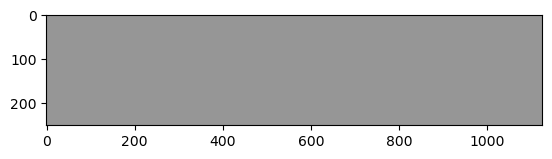

In [52]:
from matplotlib import pyplot as plt

img = draw_char(generate_text("B"), 'tmps/5b84e7224d4cb8ae721cf57b1df2df12.ttf', 250)
plt.imshow(img)
plt.show()

In [53]:
fonts

[(13, 'n/a', 'TrueType', 'Arial,Bold', 'F5', 'WinAnsiEncoding'),
 (11, 'n/a', 'TrueType', 'Times New Roman,Italic', 'F4', 'WinAnsiEncoding'),
 (5, 'n/a', 'TrueType', 'Times New Roman,Bold', 'F1', 'WinAnsiEncoding'),
 (9, 'ttf', 'TrueType', 'ABCDEE+Fake TNR Font 1', 'F3', 'WinAnsiEncoding'),
 (7, 'n/a', 'TrueType', 'Times New Roman', 'F2', 'WinAnsiEncoding')]

In [54]:
# Setup problematic font map
hashmap = {}

# Loop through embedded fonts
for filename, fontname in embedded_fonts:
    font = TTFont('tmps/' + filename)
    print(fontname)
    hashmap[fontname] = {}

    # Loop through characters
    for char in chars:
        print(char, char_in_font(char, font))
    #     if not char_in_font(char, font):
    #         continue
    #
    #     # Render characters
    #     img = draw_char(generate_text(char), 'tmps/' + filename, 250)
    #     # Detect characters with OCR
    #     result = reader.readtext(img, allowlist=chars)
    #
    #     # If character detected
    #     if len(result) > 0:
    #         # Calculate most character appear
    #         most_char, total = collections.Counter(result[0][1]).most_common(1)[0]
    #         # If char not the same
    #         if most_char.lower() != char.lower():
    #             # Add to hash map
    #             hashmap[fontname][char] = True

    # if len(hashmap[fontname].keys()) == 0:
    #     del hashmap[fontname]

# Set hashmap to data
data['fonts'] = hashmap
data

Fake TNR Font 1
0 True
1 True
2 True
3 True
4 True
5 True
6 True
7 True
8 True
9 True
a True
b True
c True
d True
e True
f True
g True
h True
i True
j True
k True
l True
m True
n True
o True
p True
q True
r True
s True
t True
u True
v True
w True
x True
y True
z True
A True
B True
C True
D True
E True
F True
G True
H True
I True
J True
K True
L True
M True
N True
O True
P True
Q True
R True
S True
T True
U True
V True
W True
X True
Y True
Z True


{'fonts': {'Fake TNR Font 1': {}}, 'pages': []}

In [55]:
char_in_font('5', font)

True

In [56]:
# Loop through pages
for page in pdf:
    page_width, page_height = page.mediabox_size  # Get page width and height
    result = page.get_text('rawdict')  # read page text as a dictionary

    items = []
    for block in result['blocks']:  # iterate through the text blocks
        if 'lines' not in block.keys():
            continue

        for line in block['lines']:  # iterate through the text lines
            for span in line['spans']:  # iterate through the text spans
                for char in span['chars']:  # iterate through text chars
                    if span['font'] in hashmap and char['c'] in hashmap[span['font']]:
                        items.append({
                            'font': span['font'],
                            'char': char['c'],
                            'rect': {
                                'x0': char['bbox'][0],
                                'y0': char['bbox'][1],
                                'x1': char['bbox'][2],
                                'y1': char['bbox'][3]
                            }
                        })

    if len(items) > 0:
        data['pages'].append({
            'page': page.number,
            'page_width': page_width,
            'page_height': page_height,
            'items': items
        })

In [57]:
# Close resource
pdf.close()